# BSS simulation

## Imports

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import random
import seaborn

from commpy.filters import rrcosfilter
from scipy.signal import convolve

from scipy.stats import kurtosis, moment
from scipy.interpolate import interp1d

## Constants

In [58]:
# specify the filename
INNAME = 'wfm.csv'
TRIALS = 100

NRANGE = 10000
NINC = 250
TRANGE = 100
TINC = 2
TRIALS = 100 #K

## Generate waveform components

In [43]:
def signal(inname=INNAME,mu=0,sigma=0.1,noise=False):
    # open the generated waveform as a pandas object
    wave = pd.read_csv(inname, header=2)
    
    # wave components
    m1 = wave['Y1'].to_numpy()
    m2 = wave['Y4'].to_numpy()
    
    #add random gaussian noise
    if noise!=False:
        noise1 = np.random.normal(mu,sigma,len(m1))
        noise2 = np.random.normal(mu,sigma,len(m2))

        m1_new = m1 + noise1
        m2_new = m2 + noise2
        s1 = m1_new
        s2 = m2_new
    
    s1 = m1
    s2 = m2
    
    return s1,s2 

In [44]:
m1,m2 = signal(noise=True)

Text(0.5, 1.0, 'Signal 1')

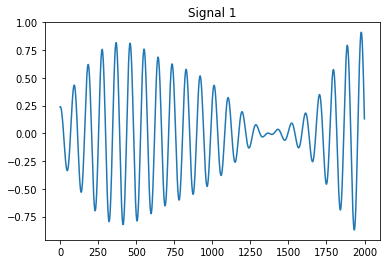

In [42]:
plt.plot(m1[:2000])
plt.title('Signal 1')

Text(0.5, 1.0, 'Signal 2')

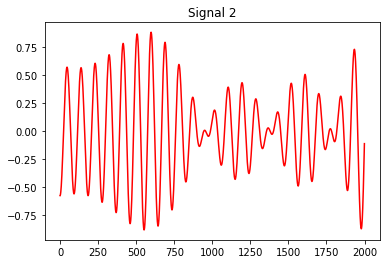

In [25]:
plt.plot(m2[:2000],color='red')
plt.title('Signal 2')

## Sampling function

The following sampling function uses scipy interp1d (with the default linear interpolation) to reconstruct data of the same frequency with a given sampling rate and interval.

In [48]:
# gets n samples spaced with period T, starting at a random time
# makes sure the signal wraps properly
def sample(signal, T, n, start = None,interp=False):
    idx = np.arange(n)
    
    if (start==None):
        start = random.randint(0,len(signal))
    idx = idx*T+start
    idx1 = idx%len(signal)
    # doing the wrapping via modulus
    if (not interp):
        return np.array(signal[idx1])
    
    func = interp1d(idx,signal[idx1])
    
    ts = np.arange((n-1)*T+1)+start
    
    return func(ts)

In [49]:
# testing
sample(m1,2,10)

array([-0.439443, -0.412656, -0.378222, -0.336838, -0.289329, -0.236634,
       -0.179784, -0.119885, -0.058095,  0.004399])

In [50]:
# get a numpy array of k sets of samples
def samples(signal,T,n,k):
    l = signal.size
#     print(l)
    rands = np.random.randint(0,l,size=k)
    samps = np.array([sample(signal,T,n,r,interp=False) for r in rands])
    return samps

In [51]:
# get the mean of the desired moment of the samples
def stats_no_var(signal,T,n,k,mom=None):
    s = samples(signal,T,n,k)
    if (mom!=None):
        return np.mean(moment(s,mom,axis=1))
    return [np.mean(moment(s,2,axis=1)),np.mean(moment(s,4,axis=1))]

In [52]:
stats_no_var(m1,T=10,n=3,k=100,mom=2)

0.03286095516370222

## Statistics function

In [53]:
# get var of the desired moment of the samples
def stats(signal,T,n,k,mom=None):
    s = samples(signal,T,n,k)
    if (mom!=None):
        return np.var(moment(s,mom,axis=1))
    return [np.var(moment(s,2,axis=1)),np.var(moment(s,4,axis=1))]

In [54]:
stats(m1,T=10,n=3,k=100,mom=2)

0.0019281545547137375

## SNR

In [55]:
def snr(signal):
    mean = np.mean(signal)
    var = moment(signal,2)
    sigma = np.sqrt(var)
    SNR = mean/sigma
    SNR_dB = 10*np.log10(SNR)
    return SNR, SNR_dB

## Simulation

Simulation:
Plotting over a range of n (number of samples) and T (period between the samples). Optionally add noise beforehand.

In [63]:
def simulation(m1,m2,nrange=NRANGE,ninc=NINC,trange=TRANGE,tinc=TINC,k=TRIALS):
    signal = m1-m2
    
    var = []
    kur = []
    
    for n in range(2*ninc,nrange,ninc):
        a = []
        b = []
        for t in range(2*tinc,trange,tinc):
            s = stats(signal,t,n,k)
            a.append(s[0])
            b.append(s[1])
        var.append(np.array(a))
        kur.append(np.array(b))
    var=np.array(var)
    kur=np.array(kur)

    return var,kur

In [64]:
var, kur = simulation(m1,m2)

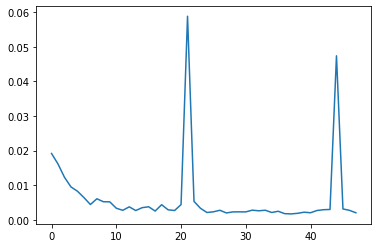

In [81]:
plt.plot(var[0,:])

In [108]:
# vary level of Gaussian noise over full range of n and T
var_signal = []
for i in (np.arange(0.0,1.0,0.1)):
    print(i)
    m1,m2 = signal(mu=0,sigma=i,noise=True)
    var, kur = simulation(m1,m2)
    var_signal.append(var)

0.0


TypeError: 'numpy.ndarray' object is not callable

In [105]:
print(np.shape(var_signal))

(10, 48)


In [101]:
SNR = []
SNR_dB = []
for i in range(0,len(var_signal)):
    signal = var_signal[i,:]
    vsnr = snr(signal)[0]
    vsnr_dB = snr(signal)[1]
    SNR.append(vsnr)
    SNR_dB.append(vsnr_dB)

0
1
2
3
4
5
6
7
8
9


In [104]:
print(np.shape(SNR))

(10,)


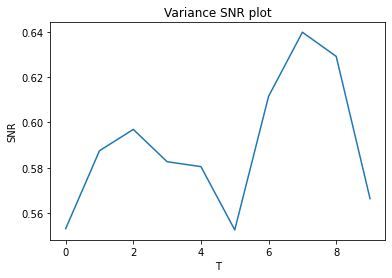

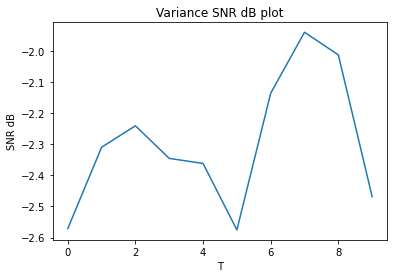

In [103]:
plt.figure(1)
plt.ylabel('SNR')
plt.xlabel('T')
plt.title('Variance SNR plot')
plt.plot(SNR)

plt.figure(2)
plt.ylabel('SNR dB')
plt.xlabel('T')
plt.title('Variance SNR dB plot')
plt.plot(SNR_dB)

## Vary number and spacing of samples

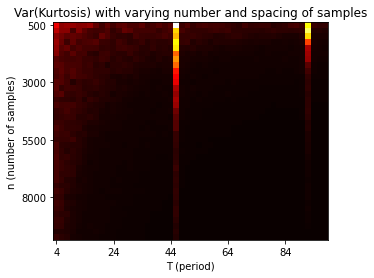

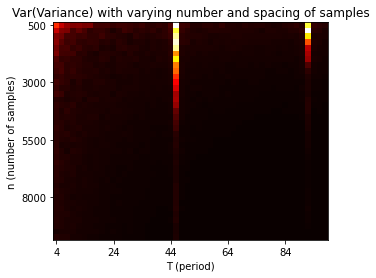

In [17]:
# Graph the var(kurtosis) across ns and Ts
plt.imshow(kur, cmap='hot', interpolation='nearest')
plt.xlabel('T (period)')
plt.ylabel('n (number of samples)')
plt.title('Var(Kurtosis) with varying number and spacing of samples')
# fig, ax = plt.subplots()

l = np.arange(2*ninc,NRANGE,ninc)
w_ticks = 10
ticks = np.arange(0,(len(l)-1)//w_ticks+1)
ticks = ticks*w_ticks

plt.yticks(ticks,l[ticks])

l2 = np.arange(2*tinc,TRANGE,tinc)
w2_ticks = 10
ticks2 = np.arange(0,(len(l2)-1)//w2_ticks+1)
ticks2 = ticks2*w2_ticks

plt.xticks(ticks2,l2[ticks2])
# ax.set_xticklabels(np.arange(2*ninc,NRANGE,ninc))
# ticks,labels = plt.xticks()
# plt.xticks(range(2*ninc,NRANGE,ninc))
plt.show()

# Graph the var(variance) across ns and Ts
plt.imshow(var, cmap='hot', interpolation='nearest')
plt.xlabel('T (period)')
plt.ylabel('n (number of samples)')
plt.title('Var(Variance) with varying number and spacing of samples')
# fig, ax = plt.subplots()

plt.yticks(ticks,l[ticks])
plt.xticks(ticks2,l2[ticks2])

# ax.set_xticklabels(np.arange(2*ninc,NRANGE,ninc))
# ticks,labels = plt.xticks()
# plt.xticks(range(2*ninc,NRANGE,ninc))
plt.show()

We see a very high variance when T = 46 or T = 92. This might be due to some artifact of the interaction of sampling time with length of the data set, though the signal has 523008 data points which is not a multiple of 46.
This got less prominent when we did interpolation

## Different mixes

-39
-37
-35
-33
-31
-29
-27
-25
-23
-21
-19
-17
-15
-13
-11
-9
-7
-5
-3
-1
1
3
5
7
9
11
13
15
17
19
21
23
25
27
29
31
33
35
37


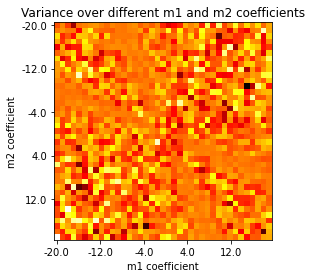

-39
-37
-35
-33
-31
-29
-27
-25
-23
-21
-19
-17
-15
-13
-11
-9
-7
-5
-3
-1
1
3
5
7
9
11
13
15
17
19
21
23
25
27
29
31
33
35
37


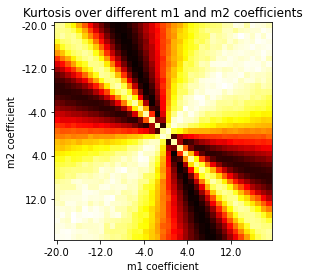

In [18]:
# LOOK AT THESE STATS OVER DIFFERENT MIXES
test_t = 25
test_n = 10000
mom = 2
M = 400

w = 39 # density of plots, make it odd
r = 20 # width of actual range

a = []
for i in range(-w,w,2):
    b = []
    print(i)
    for j in range(-w,w,2):
        m = m1*r/w*j+m2*r/w*i
        norm = np.linalg.norm(m)
        if (norm!=0):
            m=m/norm
        b.append(stats_no_var(m,test_t,test_n,M,mom))
    a.append(np.array(b))
a = np.array(a)

plt.yticks(np.arange(0,w,w/5),np.arange(-r,r,2*r/5))
plt.xticks(np.arange(0,w,w/5),np.arange(-r,r,2*r/5))

plt.title('Variance over different m1 and m2 coefficients')
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.xlabel('m1 coefficient')
plt.ylabel('m2 coefficient')
plt.show()

mom=4
a = []
for i in range(-w,w,2):
    b = []
    print(i)
    for j in range(-w,w,2):
        m = m1*r/w*j+m2*r/w*i
        norm = np.linalg.norm(m)
        if (norm!=0):
            m=m/norm
        b.append(stats_no_var(m,test_t,test_n,M,mom))
    a.append(np.array(b))
a = np.array(a)

plt.yticks(np.arange(0,w,w/5),np.arange(-r,r,2*r/5))
plt.xticks(np.arange(0,w,w/5),np.arange(-r,r,2*r/5))

plt.title('Kurtosis over different m1 and m2 coefficients')
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.xlabel('m1 coefficient')
plt.ylabel('m2 coefficient')
plt.show()

We see that the highest var mix is 1:-1, and the lowest var mix is 1:1

## Vary sampling rate and period

10
20
30
40
50
60
70
80
90


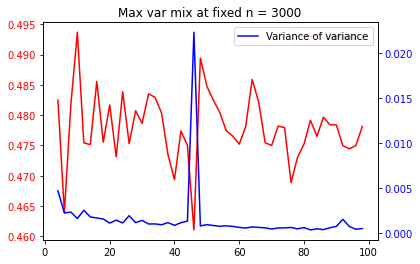

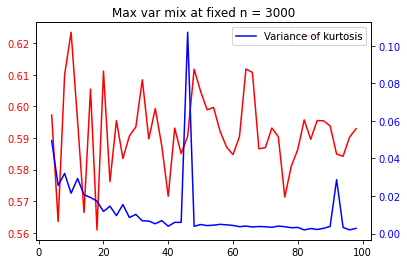

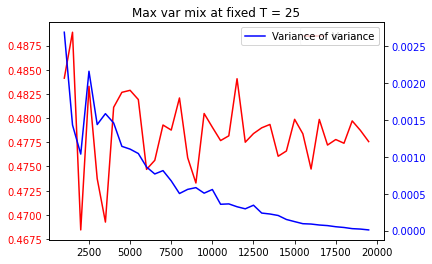

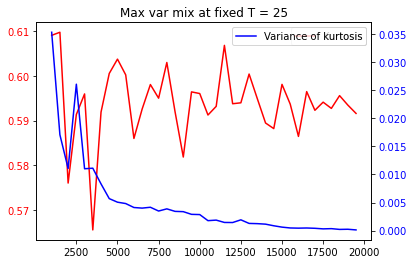

In [19]:
# graph var and kur at different sampling rates and periods
num_samp = 3000
samp_gap = 25
MAX_SIGNAL = m1-m2 # max variance and kur mix is 1:-1
MIN_SIGNAL = m1+m2 # min variance and kur mix is 1:1

M = 50

NRANGE = 20000
ninc = 500
TRANGE = 100
tinc = 2

# vary the time gap
def statistic_var_t(signal,signal_name = None):
    var = []
    kur = []
    vvar = []
    vkur = []
    for t in range(2*tinc,TRANGE,tinc):
        if (t%(tinc*5)==0):
            print(t)
        va = stats(signal,t,num_samp,M)
        a = stats_no_var(signal,t,num_samp,M)
        
        var.append(np.array(a[0]))
        kur.append(np.array(a[1]))
        vvar.append(np.array(va[0]))
        vkur.append(np.array(va[1]))
        
    l = np.arange(2*tinc,TRANGE,tinc)
    
    # plot variance and vvariance
    fig,ax = plt.subplots()
    ax.plot(l,var,color='red',label='Variance')
    ax.tick_params(axis='y', labelcolor='red')
    ax.legend()
    
    ax2 = ax.twinx()
    ax2.plot(l,vvar,color='blue',label='Variance of variance')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.legend()

# ax2.set_yscale('log')
    plt.xlabel("T (period)")
    plt.title(str(signal_name)+" at fixed n = "+str(num_samp))
    plt.show()
    
    
    # plot kur and vkur
    fig,ax = plt.subplots()
    ax.plot(l,kur,color='red',label='Kurtosis')
    ax.tick_params(axis='y', labelcolor='red')
    ax.legend()
    
    ax2 = ax.twinx()
    ax2.plot(l,vkur,color='blue',label='Variance of kurtosis')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.legend()

# ax2.set_yscale('log')
    plt.xlabel("T (period)")
    plt.title(str(signal_name)+" at fixed n = "+str(num_samp))
    plt.show()

def statistic_var_n(signal,signal_name = None):
    var = []
    kur = []
    vvar = []
    vkur = []
    for n in range(2*ninc,NRANGE,ninc):
        va = stats(signal,samp_gap,n,M)
        a = stats_no_var(signal,samp_gap,n,M)
        
        var.append(np.array(a[0]))
        kur.append(np.array(a[1]))
        vvar.append(np.array(va[0]))
        vkur.append(np.array(va[1]))
        
    l = np.arange(2*ninc,NRANGE,ninc)
#     w_ticks = 10
#     ticks = np.arange(0,(len(l)-1)//w_ticks+1)
#     ticks = ticks*w_ticks
    
    # plot variance and vvariance
    fig,ax = plt.subplots()
    ax.plot(l,var,color='red',label='Variance')
    ax.tick_params(axis='y', labelcolor='red')
    ax.legend()
    
    ax2 = ax.twinx()
    ax2.plot(l,vvar,color='blue',label='Variance of variance')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.legend()

# ax2.set_yscale('log')
    plt.xlabel("n (number of samples)")
    plt.title(str(signal_name)+" at fixed T = "+str(samp_gap))
    plt.show()
    
    
    # plot kur and vkur
    fig,ax = plt.subplots()
    ax.plot(l,kur,color='red',label='Kurtosis')
    ax.tick_params(axis='y', labelcolor='red')
    ax.legend()
    
    ax2 = ax.twinx()
    ax2.plot(l,vkur,color='blue',label='Variance of kurtosis')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.legend()

# ax2.set_yscale('log')
    plt.xlabel("n (number of samples)")
    plt.title(str(signal_name)+" at fixed T = "+str(samp_gap))
    plt.show()
    
statistic_var_t(MAX_SIGNAL,'Max var mix')
# statistic_var_t(MAX_SIGNAL,'Min var mix')
statistic_var_n(MAX_SIGNAL,'Max var mix')
# statistic_var_n(MAX_SIGNAL,'Min var mix')

## Extra code for reference

In [ ]:
# vary the level of noise by varying the stdev of the noise level
noisy_signals_m1 = []
noisy_signals_m2 = []
mu = 0
for i in np.arange(0, 1.0, 0.1):
    row1 = gaussian_noise(m1,mu,i)
    noisy_signals_m1.append(row1)
    
    row2 = gaussian_noise(m2,mu,i)
    noisy_signals_m2.append(row2)
#print(np.shape(noisy_signals))
    
plt.plot(noisy_signals_m2[1],color='red')
plt.xlim([0, 2000])

In [ ]:
# treat var and kurt as "signal" and find snr over 3 different noise levels
vsnr1 = snr(var1)[0]
vsnr_dB1 = snr(var1)[1]
ksnr1 = snr(kur1)[0]
ksnr_dB1 = snr(kur1)[1]

vsnr2 = snr(var2)[0]
vsnr_dB2 = snr(var2)[1]
ksnr2 = snr(kur2)[0]
ksnr_dB2 = snr(kur2)[1]

vsnr3 = snr(var3)[0]
vsnr_dB3 = snr(var3)[1]
ksnr3 = snr(kur3)[0]
ksnr_dB3 = snr(kur3)[1]


plt.figure(1)
plt.ylabel('SNR')
plt.title('Variance SNR plot w noise')
plt.plot(vsnr1,label = "stdev = 0.2")
plt.plot(vsnr2,label = "stdev = 0.5")
plt.plot(vsnr3,label = "stdev = 0.8")
plt.legend()

plt.figure(2)
plt.ylabel('SNR dB')
plt.title('Variance SNR dB plot w noise')
plt.plot(vsnr_dB1,label = "stdev = 0.2")
plt.plot(vsnr_dB2,label = "stdev = 0.5")
plt.plot(vsnr_dB3,label = "stdev = 0.8")
plt.legend()

plt.figure(3)
plt.ylabel('SNR')
plt.title('Kurtosis SNR plot w noise')
plt.plot(ksnr1,label = "stdev = 0.2")
plt.plot(ksnr2,label = "stdev = 0.5")
plt.plot(ksnr3,label = "stdev = 0.8")

plt.figure(4)
plt.ylabel('SNR dB')
plt.title('Kurtosis SNR dB plot w noise')
plt.plot(ksnr_dB1,label = "stdev = 0.2")
plt.plot(ksnr_dB2,label = "stdev = 0.5")
plt.plot(ksnr_dB3,label = "stdev = 0.8")